In [ ]:
!pip install tensorflow-text
!pip install contractions
!pip install -q tf-models-official==2.7.0
!pip install pretty-confusion-matrix
!pip install matplotlib==3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 588.3 MB 17 kB/s 
     |████████████████████████████████| 6.0 MB 38.9 MB/s 
     |████████████████████████████████| 439 kB 50.4 MB/s 
     |████████████████████████████████| 1.7 MB 40.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pretty-confusion-matrix 0.1.1 requires matplotlib<4.0.0,>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
import re, string, unicodedata
import contractions
import inflect
from tqdm import tqdm
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.metrics import f1_score
import os
import shutil
import sys
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report ,cohen_kappa_score ,confusion_matrix ,plot_confusion_matrix ,accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
sys.path.append('models')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/newdatasetwithcoviddata.csv")
train = train[:120000]
train.head()

,text,label
0,why don t we do it in the road to perdition ad...,0
1,what is the lead time time between diagnosis w...,1
2,covid and ppe some of us will die,1
3,covid antibodies can disappear after months st...,1
4,lab made coronavirus triggers debate the scien...,0


In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
  """Remove URLs from a sample string"""
  return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


def replace_numbers(words):
  """Replace all interger occurrences in list of tokenized words with textual representation"""
  p = inflect.engine()
  new_words = []
  for word in words:
      if word.isdigit():
          new_word = p.number_to_words(word)
          new_words.append(new_word)
      else:
          new_words.append(word)
  return new_words

In [ ]:
text_preprocess=[]
labels = []
for i in tqdm(train.index):
  text = train['text'][i]
  labels.append(int(train['label'][i]))
  text = remove_URL(text)
  text = replace_contractions(text)
  text = word_tokenize(text)
  text = remove_non_ascii(text)
  text = to_lowercase(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  text = replace_numbers(text)
  text = " ".join(text)
  text_preprocess.append(text)

100%|██████████| 120000/120000 [04:15<00:00, 469.72it/s]


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(text_preprocess, labels, test_size=0.33, random_state=100)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=100)
print(len(x_train))
print(len(x_val))
print(len(x_test))

80400
19800
19800


In [ ]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_val = Encoder.fit_transform(y_val)
y_test = Encoder.fit_transform(y_test)

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(text_preprocess)
Train_X_Tfidf = Tfidf_vect.transform(x_train)
val_X_Tfidf = Tfidf_vect.transform(x_val)
Test_X_Tfidf = Tfidf_vect.transform(x_test)


In [ ]:
print(Tfidf_vect.vocabulary_)


{'road': 3809, 'midnight': 2761, 'lead': 2477, 'time': 4503, 'diagnosis': 1184, 'symptoms': 4366, 'hospitalization': 2091, 'covid': 984, 'ppe': 3358, 'us': 4710, 'die': 1191, 'antibodies': 209, 'disappear': 1219, 'months': 2836, 'study': 4283, 'shows': 4042, 'via': 4762, 'medscape': 2720, 'lab': 2434, 'made': 2615, 'coronavirus': 941, 'triggers': 4608, 'debate': 1072, 'scientist': 3907, 'magazine': 2619, 'fabric': 1586, 'know': 2423, 'webmd': 4867, 'locked': 2568, 'country': 967, 'governors': 1896, 'used': 4714, 'practical': 3363, 'tips': 4510, 'staying': 4217, 'safe': 3850, 'flattenthecurve': 1714, 'work': 4943, 'closed': 745, 'due': 1333, 'caring': 607, 'someone': 4129, 'experiencing': 1557, 'symptom': 4365, 'cms': 762, 'hikes': 2046, 'telephone': 4420, 'visit': 4789, 'payments': 3184, 'pandemic': 3133, 'today': 4516, 'discussed': 1230, 'non': 2968, 'materials': 2680, 'conducted': 848, 'welcomes': 4882, 'preliminary': 3381, 'results': 3763, 'dexamethasone': 1176, 'use': 4713, 'treati

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)

Naive Bayes Accuracy Score ->  91.33333333333333


In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(predictions_NB, y_test, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.62      0.85      0.72      2541
     class 1       0.98      0.92      0.95     17259

    accuracy                           0.91     19800
   macro avg       0.80      0.89      0.83     19800
weighted avg       0.93      0.91      0.92     19800



In [ ]:
print(cohen_kappa_score(predictions_NB, y_test))

0.6669467988269384


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

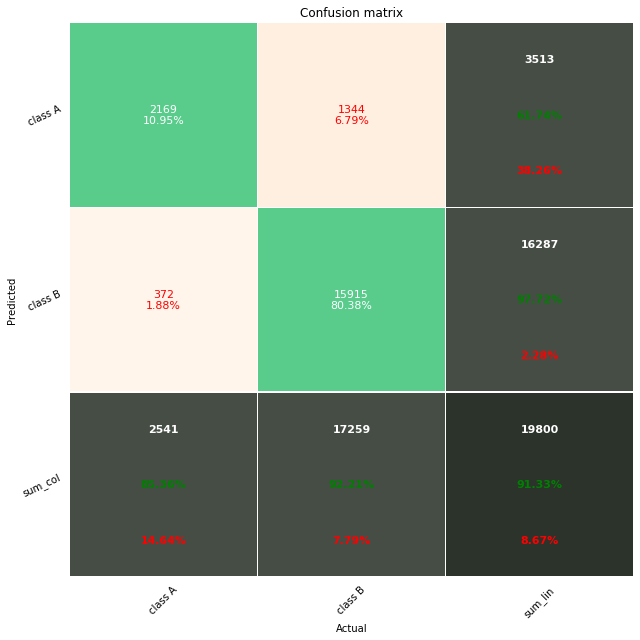

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data
pp_matrix_from_data(predictions_NB, y_test)

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  93.12121212121211


In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(predictions_SVM, y_test, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.75      0.84      0.80      3143
     class 1       0.97      0.95      0.96     16657

    accuracy                           0.93     19800
   macro avg       0.86      0.90      0.88     19800
weighted avg       0.94      0.93      0.93     19800



In [ ]:
print(cohen_kappa_score(predictions_SVM, y_test))

0.7541831819315177


In [ ]:
# Classifier - Algorithm - MLP

mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(Train_X_Tfidf,y_train)
# predict the labels on validation dataset
predictions_mlp = mlp.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("MLP Accuracy Score -> ",accuracy_score(predictions_mlp, y_test)*100)

MLP Accuracy Score ->  93.1969696969697


In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(predictions_mlp, y_test, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.80      0.81      0.81      3488
     class 1       0.96      0.96      0.96     16312

    accuracy                           0.93     19800
   macro avg       0.88      0.88      0.88     19800
weighted avg       0.93      0.93      0.93     19800



In [ ]:
print(cohen_kappa_score(predictions_mlp, y_test))

0.766279268590975


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

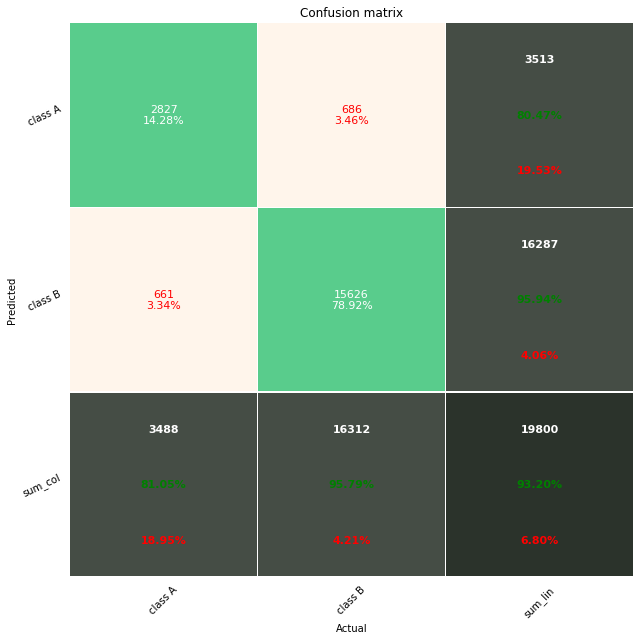

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data
pp_matrix_from_data(predictions_mlp, y_test)